In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import sounddevice as sd
import soundfile as sf
import librosa
import audiolazy
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset as TorchDataset
from torch.utils.data import DataLoader
from torchsummary import summary
from tqdm import tqdm
import torch
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

import analysis

In [2]:
# For constant
categories = {0: "tram",
             1: "car"}

In [3]:
DATA_DIR = "./data"

# Load train data
class0_train_dir = os.path.join(DATA_DIR, "normalized_train_tram") 
class1_train_dir = os.path.join(DATA_DIR, "normalized_train_car") 
 
class0_train_files = [os.path.join(class0_train_dir, file) for file in os.listdir(class0_train_dir)]
class1_train_files = [os.path.join(class1_train_dir, file) for file in os.listdir(class1_train_dir)]

# Load validation data
class0_valid_dir = os.path.join(DATA_DIR, "normalized_valid_tram") 
class1_valid_dir = os.path.join(DATA_DIR, "normalized_valid_car") 
 
class0_valid_files = [os.path.join(class0_valid_dir, file) for file in os.listdir(class0_valid_dir)]
class1_valid_files = [os.path.join(class1_valid_dir, file) for file in os.listdir(class1_valid_dir)]

# Load test data
class0_test_dir = os.path.join(DATA_DIR, "normalized_test_tram") 
class1_test_dir = os.path.join(DATA_DIR, "normalized_test_car") 
 
class0_test_files = [os.path.join(class0_test_dir, file) for file in os.listdir(class0_test_dir)]
class1_test_files = [os.path.join(class1_test_dir, file) for file in os.listdir(class1_test_dir)]

Class tram
./data/normalized_train_tram/train_tram_006.wav


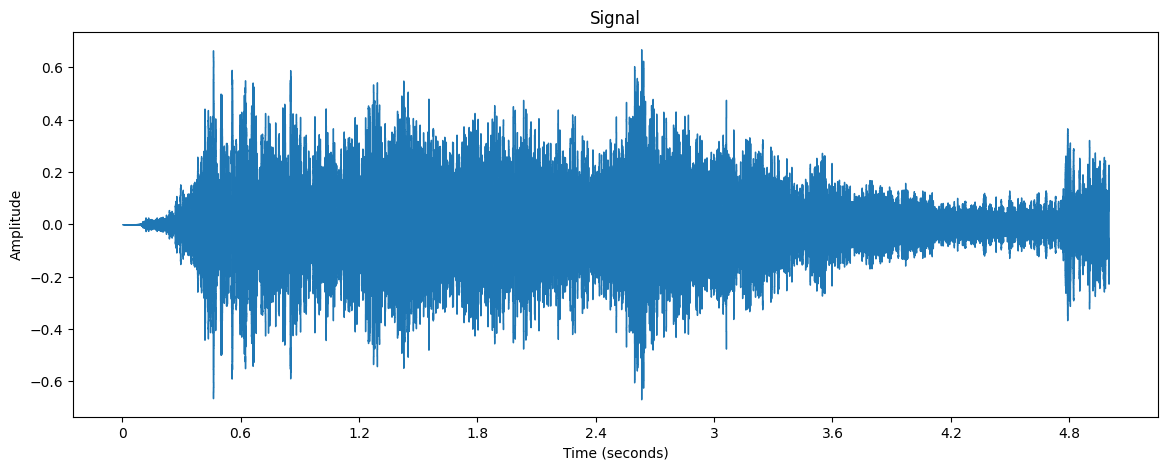

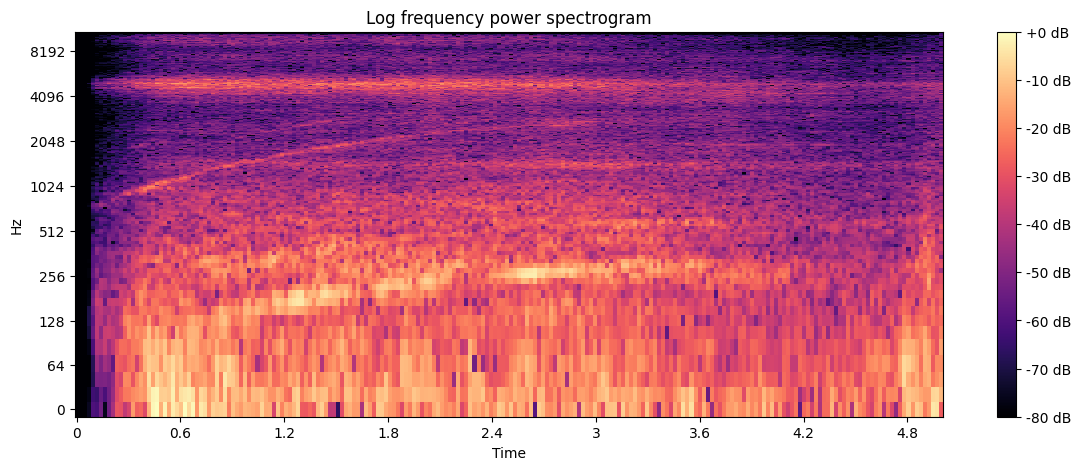

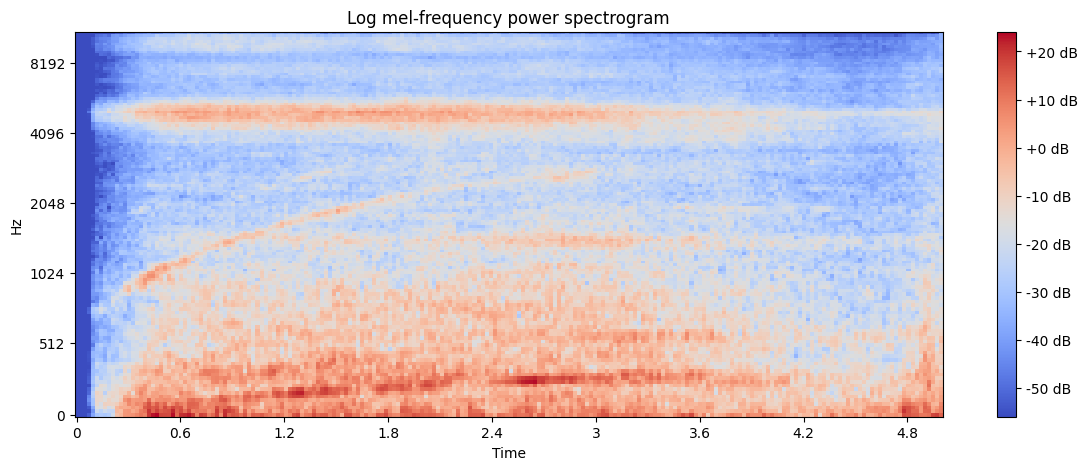

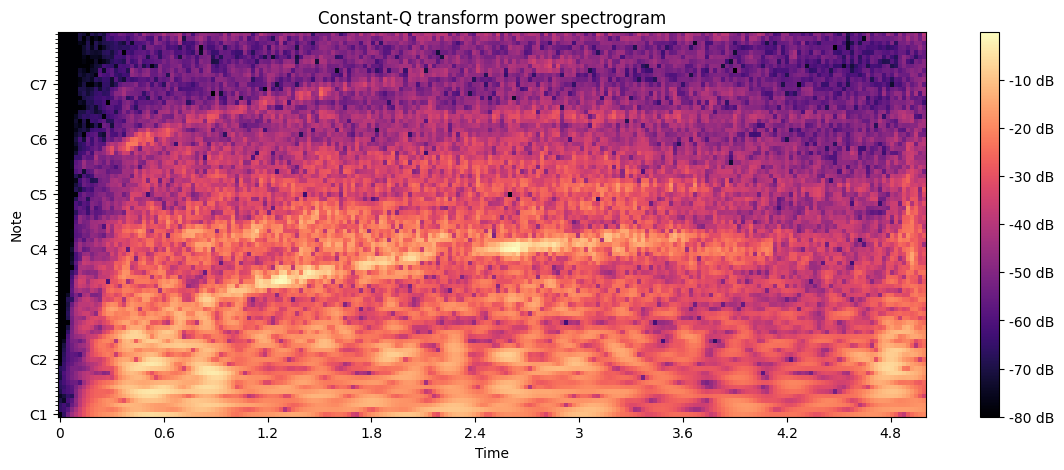

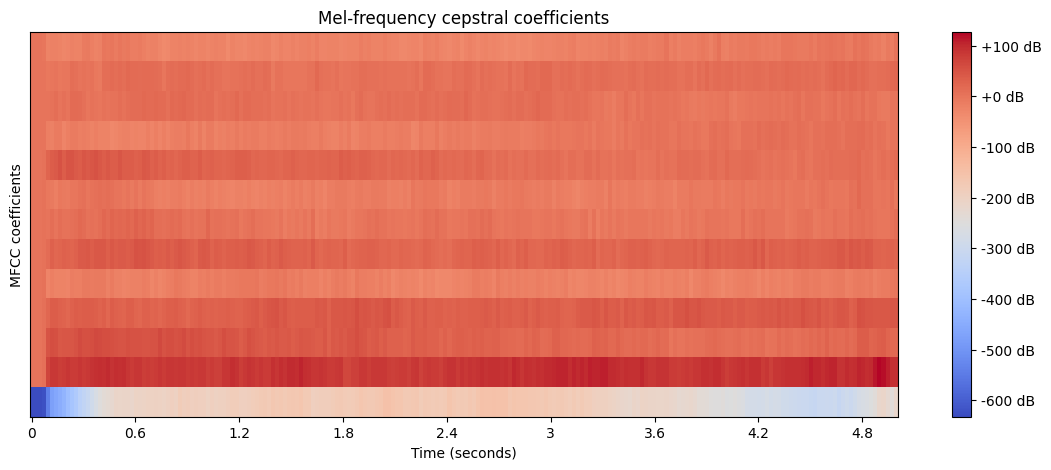

In [21]:
# Feature analysis
# Class 0
sample_file = class0_train_files[8]

print(f"Class {categories[0]}")
print(sample_file)

features = analysis.feature_extraction(sample_file)

Class car
./data/normalized_train_car/train_car_043.wav


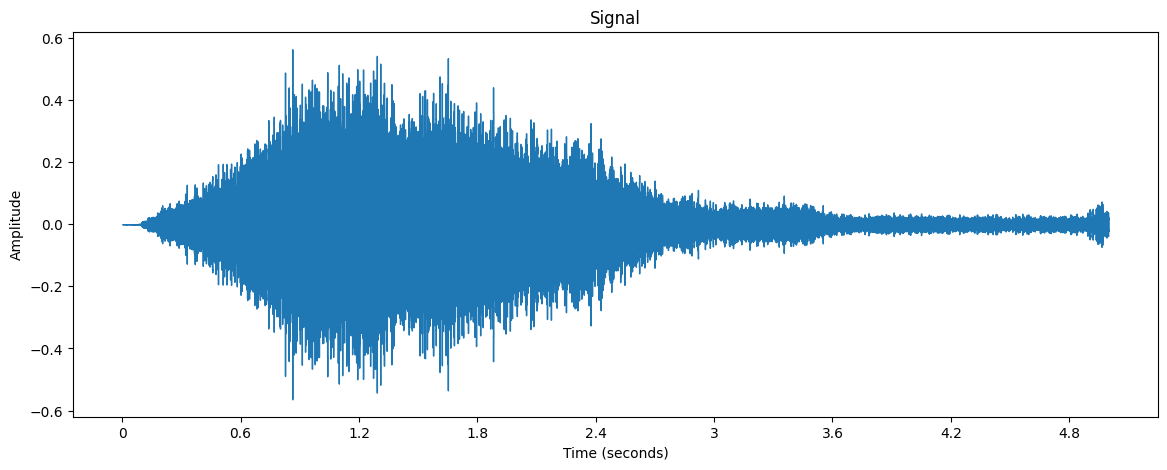

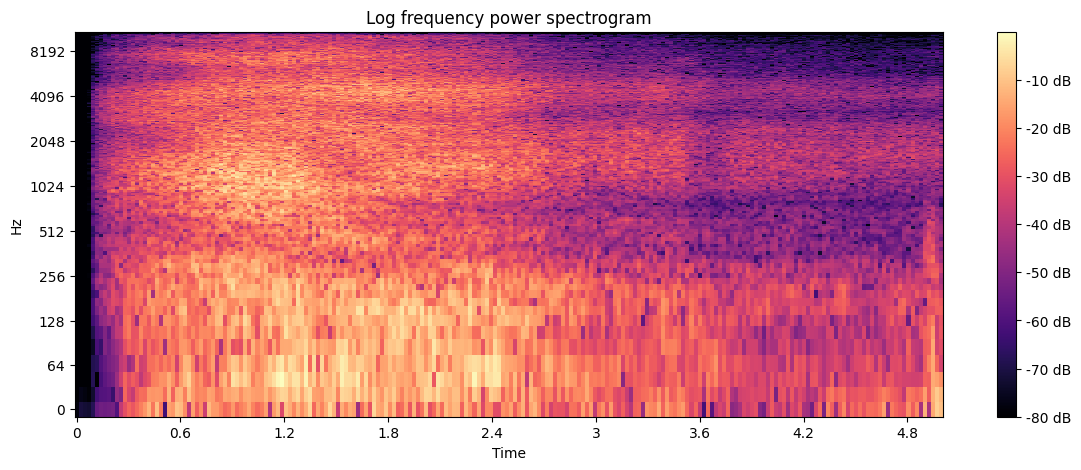

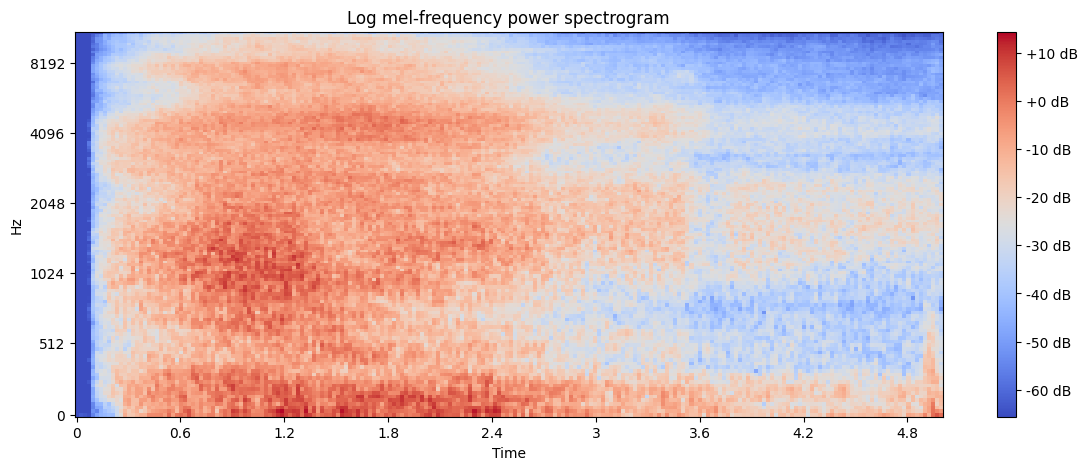

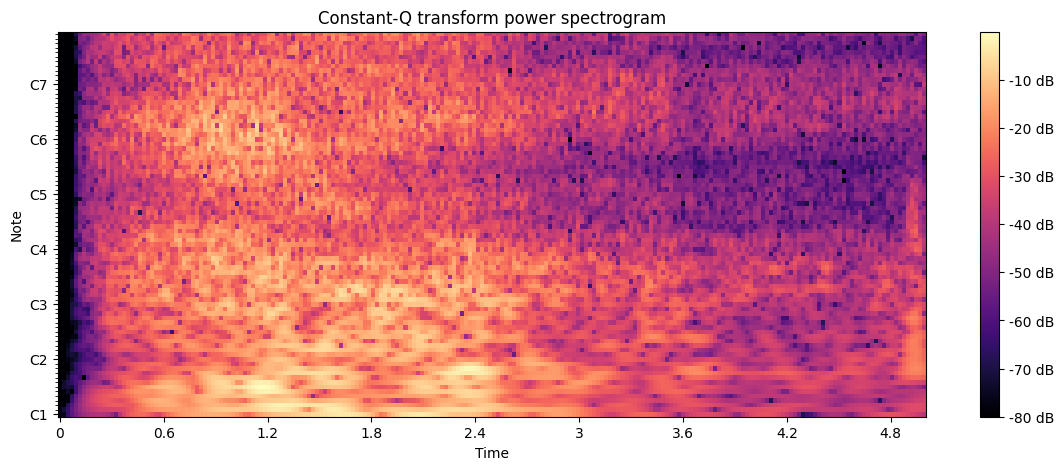

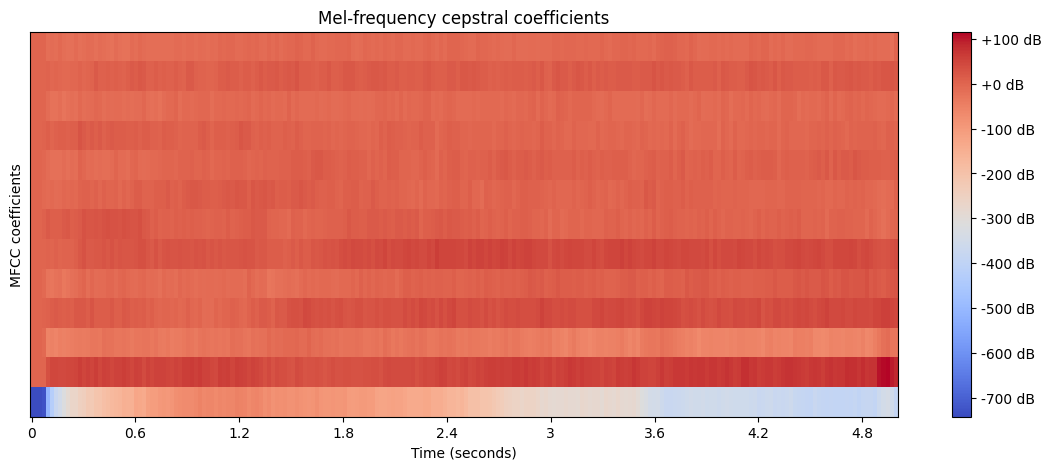

In [5]:
# Class 1
sample_file = class1_train_files[2]

print(f"Class {categories[1]}")
print(sample_file)

features = analysis.feature_extraction(sample_file)

In [6]:
# Extract features
class0_train_features = [analysis.feature_extraction(file, is_plot = False) for file in class0_train_files]
class0_valid_features = [analysis.feature_extraction(file, is_plot = False) for file in class0_valid_files]
class0_test_features = [analysis.feature_extraction(file, is_plot = False) for file in class0_test_files]

class1_train_features = [analysis.feature_extraction(file, is_plot = False) for file in class1_train_files]
class1_valid_features = [analysis.feature_extraction(file, is_plot = False) for file in class1_valid_files]
class1_test_features = [analysis.feature_extraction(file, is_plot = False) for file in class1_test_files]

In [7]:
# List of values for energy, rms, zcr
class0_energy = [feature["energy"] 
                 for feature in class0_train_features + class0_valid_features + class0_test_features]
class0_rms = [feature["rms"]
              for feature in class0_train_features + class0_valid_features + class0_test_features]
class0_zcr = [feature["zcr"]
              for feature in class0_train_features + class0_valid_features + class0_test_features]

class1_energy = [feature["energy"] 
                 for feature in class1_train_features + class1_valid_features + class1_test_features]
class1_rms = [feature["rms"]
              for feature in class1_train_features + class1_valid_features + class1_test_features]
class1_zcr = [feature["zcr"]
              for feature in class1_train_features + class1_valid_features + class1_test_features]

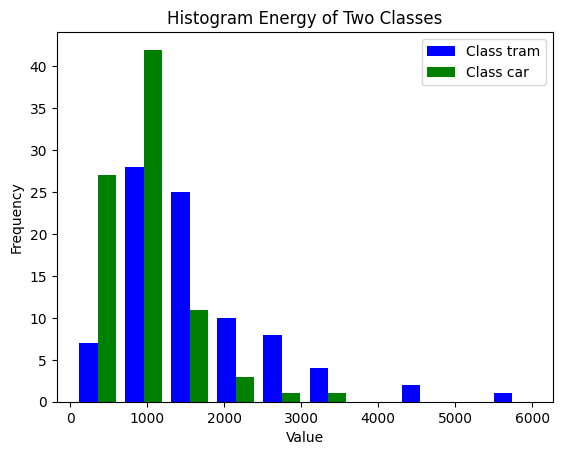

In [8]:
# Creating the histogram for energy
plt.hist([class0_energy, class1_energy], color=['blue', 'green'], 
         label=[f'Class {categories[0]}', f'Class {categories[1]}'])

# Adding title and labels
plt.title('Histogram Energy of Two Classes')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()

# Display the histogram
plt.show()

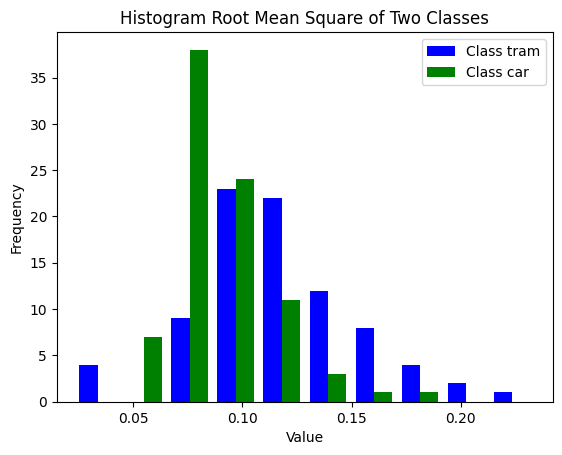

In [9]:
# Creating the histogram for RMS
plt.hist([class0_rms, class1_rms], color=['blue', 'green'], 
         label=[f'Class {categories[0]}', f'Class {categories[1]}'])

# Adding title and labels
plt.title('Histogram Root Mean Square of Two Classes')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()

# Display the histogram
plt.show()


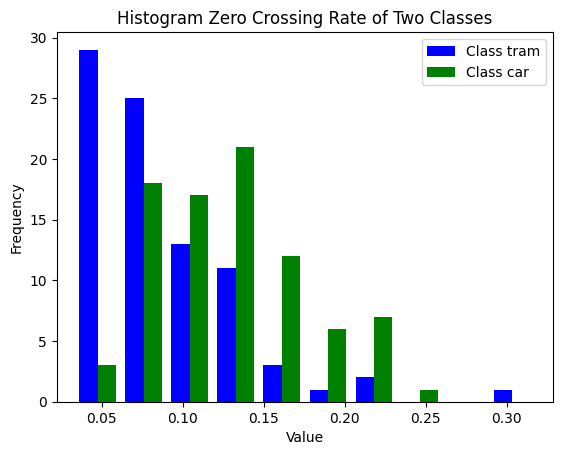

In [10]:
# Creating the histogram for zero cross rate
plt.hist([class0_zcr, class1_zcr], color=['blue', 'green'], 
         label=[f'Class {categories[0]}', f'Class {categories[1]}'])

# Adding title and labels
plt.title('Histogram Zero Crossing Rate of Two Classes')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()

# Display the histogram
plt.show()


# Binary classification

## Dataset

In [11]:
# Define Dataset class
class Dataset(TorchDataset):
    def __init__(self, *args):
        super().__init__()
        self.x = np.array([item[0] for item in args[0]])
        self.y = np.array([item[1] for item in args[0]])

    def __len__(self):
        return self.y.shape[0]

    def __getitem__(self, idx):
        x = self.x[idx]
        y = self.y[idx]
        return x, y


In [12]:
# Concatenate features of all class spectrogram, mel_spectrogram, cqt, mfcc

# Train
class0_train_x = [np.concatenate([feature['log_spectrogram'], 
                            feature['logmel_spectrogram'],
                            feature['cqt_spectrogram'],
                            feature['mfcc']], axis = 0) for feature in class0_train_features]
class0_train_y = [0 for i in range(len(class0_train_features))]


class1_train_x = [np.concatenate([feature['log_spectrogram'], 
                            feature['logmel_spectrogram'],
                            feature['cqt_spectrogram'],
                            feature['mfcc']], axis = 0) for feature in class1_train_features]
class1_train_y = [1 for i in range(len(class1_train_features))]


# Train split
class0_train = list(zip(class0_train_x, class0_train_y))
class1_train = list(zip(class1_train_x, class1_train_y))
train = class0_train + class1_train

# Validation
class0_valid_x = [np.concatenate([feature['log_spectrogram'], 
                            feature['logmel_spectrogram'],
                            feature['cqt_spectrogram'],
                            feature['mfcc']], axis = 0) for feature in class0_valid_features]
class0_valid_y = [0 for i in range(len(class0_valid_features))]


class1_valid_x = [np.concatenate([feature['log_spectrogram'], 
                            feature['logmel_spectrogram'],
                            feature['cqt_spectrogram'],
                            feature['mfcc']], axis = 0) for feature in class1_train_features]
class1_valid_y = [1 for i in range(len(class1_valid_features))]


# Validation split
class0_valid = list(zip(class0_valid_x, class0_valid_y))
class1_valid = list(zip(class1_valid_x, class1_valid_y))
valid = class0_valid + class1_valid


# Test
class0_test_x = [np.concatenate([feature['log_spectrogram'], 
                            feature['logmel_spectrogram'],
                            feature['cqt_spectrogram'],
                            feature['mfcc']], axis = 0) for feature in class0_test_features]
class0_test_y = [0 for i in range(len(class0_test_features))]


class1_test_x = [np.concatenate([feature['log_spectrogram'], 
                            feature['logmel_spectrogram'],
                            feature['cqt_spectrogram'],
                            feature['mfcc']], axis = 0) for feature in class1_test_features]
class1_test_y = [1 for i in range(len(class1_test_features))]


# Test split
class0_test = list(zip(class0_test_x, class0_test_y))
class1_test = list(zip(class1_test_x, class1_test_y))
test = class0_test + class1_test

In [13]:
# Construct dataset
train_dataset = Dataset(train)
valid_dataset = Dataset(valid)
test_dataset = Dataset(test)

# Construct dataloader
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=True)

# Define model

In [14]:
class Simple1DNet(nn.Module):
    def __init__(self):
        super(Simple1DNet, self).__init__()
        # Define your layers here
        self.conv1 = nn.Conv1d(in_channels=738, out_channels=64, kernel_size=3, stride=2)
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=32, kernel_size=3, stride=2)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2, padding=1)
        self.fc = nn.Linear(32*27, 1)  # Adjust the size according to your pooling and conv layers
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        # Define the forward pass
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        x = torch.flatten(x, start_dim=1)
        x = self.fc(x)
        x = self.sigmoid(x)
        return x


In [15]:
# Define model
model = Simple1DNet()
#x = torch.rand((1, 738, 216))
#model(x)
# Model summary
model_summary = summary(model, input_size=(738, 216), device="cpu")
model_summary

# Number of params
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(total_params)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 64, 107]         141,760
              ReLU-2              [-1, 64, 107]               0
            Conv1d-3               [-1, 32, 53]           6,176
              ReLU-4               [-1, 32, 53]               0
         MaxPool1d-5               [-1, 32, 27]               0
            Linear-6                    [-1, 1]             865
           Sigmoid-7                    [-1, 1]               0
Total params: 148,801
Trainable params: 148,801
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.61
Forward/backward pass size (MB): 0.14
Params size (MB): 0.57
Estimated Total Size (MB): 1.31
----------------------------------------------------------------
148801


## Training

In [16]:
# Training hyperparameters
num_epochs = 100
lr = 0.0001
# Training loss and optimizer
loss_fun = nn.BCELoss()  
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

model.train()
# Training loop
for epoch in tqdm(range(num_epochs)):
    for i, (inputs, labels) in enumerate(train_loader):  # Assuming you have a DataLoader
        # Forward pass
        outputs = model(inputs)
        # Remove dim with 1
        outputs = torch.squeeze(outputs)
       
        labels = labels.float()
        loss = loss_fun(outputs, labels)
        #print(outputs)
        print(loss)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


  0%|                                                   | 0/100 [00:00<?, ?it/s]

tensor(1.8035, grad_fn=<BinaryCrossEntropyBackward0>)


  1%|▍                                          | 1/100 [00:00<00:45,  2.17it/s]

tensor(0.9543, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.0211, grad_fn=<BinaryCrossEntropyBackward0>)


  2%|▊                                          | 2/100 [00:00<00:31,  3.11it/s]

tensor(0.7614, grad_fn=<BinaryCrossEntropyBackward0>)


  3%|█▎                                         | 3/100 [00:01<00:33,  2.86it/s]

tensor(0.7797, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5405, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5983, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6634, grad_fn=<BinaryCrossEntropyBackward0>)


  5%|██▏                                        | 5/100 [00:01<00:33,  2.84it/s]

tensor(0.6246, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.4720, grad_fn=<BinaryCrossEntropyBackward0>)


  6%|██▌                                        | 6/100 [00:01<00:28,  3.25it/s]

tensor(0.5590, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.4767, grad_fn=<BinaryCrossEntropyBackward0>)


  7%|███                                        | 7/100 [00:02<00:26,  3.57it/s]

tensor(0.5024, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.4766, grad_fn=<BinaryCrossEntropyBackward0>)


  8%|███▍                                       | 8/100 [00:02<00:25,  3.67it/s]

tensor(0.4573, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.4426, grad_fn=<BinaryCrossEntropyBackward0>)


  9%|███▊                                       | 9/100 [00:02<00:25,  3.63it/s]

tensor(0.4352, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.3384, grad_fn=<BinaryCrossEntropyBackward0>)


 10%|████▏                                     | 10/100 [00:02<00:23,  3.87it/s]

tensor(0.3867, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.3180, grad_fn=<BinaryCrossEntropyBackward0>)


 11%|████▌                                     | 11/100 [00:03<00:23,  3.78it/s]

tensor(0.3333, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.3316, grad_fn=<BinaryCrossEntropyBackward0>)


 12%|█████                                     | 12/100 [00:03<00:23,  3.76it/s]

tensor(0.2971, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.3205, grad_fn=<BinaryCrossEntropyBackward0>)


 13%|█████▍                                    | 13/100 [00:03<00:24,  3.59it/s]

tensor(0.2758, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2921, grad_fn=<BinaryCrossEntropyBackward0>)


 14%|█████▉                                    | 14/100 [00:04<00:23,  3.69it/s]

tensor(0.2678, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2134, grad_fn=<BinaryCrossEntropyBackward0>)


 15%|██████▎                                   | 15/100 [00:04<00:22,  3.84it/s]

tensor(0.2264, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2424, grad_fn=<BinaryCrossEntropyBackward0>)


 16%|██████▋                                   | 16/100 [00:04<00:20,  4.03it/s]

tensor(0.2195, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1965, grad_fn=<BinaryCrossEntropyBackward0>)


 17%|███████▏                                  | 17/100 [00:04<00:20,  4.07it/s]

tensor(0.2055, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1359, grad_fn=<BinaryCrossEntropyBackward0>)


 18%|███████▌                                  | 18/100 [00:05<00:19,  4.16it/s]

tensor(0.1674, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2334, grad_fn=<BinaryCrossEntropyBackward0>)


 19%|███████▉                                  | 19/100 [00:05<00:18,  4.31it/s]

tensor(0.1496, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1463, grad_fn=<BinaryCrossEntropyBackward0>)


 20%|████████▍                                 | 20/100 [00:05<00:18,  4.43it/s]

tensor(0.1832, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1042, grad_fn=<BinaryCrossEntropyBackward0>)


 21%|████████▊                                 | 21/100 [00:05<00:17,  4.53it/s]

tensor(0.1131, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1446, grad_fn=<BinaryCrossEntropyBackward0>)


 22%|█████████▏                                | 22/100 [00:05<00:16,  4.62it/s]

tensor(0.1209, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1204, grad_fn=<BinaryCrossEntropyBackward0>)


 23%|█████████▋                                | 23/100 [00:06<00:16,  4.72it/s]

tensor(0.1168, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0801, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0879, grad_fn=<BinaryCrossEntropyBackward0>)


 24%|██████████                                | 24/100 [00:06<00:15,  4.81it/s]

tensor(0.1179, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0901, grad_fn=<BinaryCrossEntropyBackward0>)


 25%|██████████▌                               | 25/100 [00:06<00:15,  4.83it/s]

tensor(0.0747, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0715, grad_fn=<BinaryCrossEntropyBackward0>)


 26%|██████████▉                               | 26/100 [00:06<00:15,  4.84it/s]

tensor(0.1261, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0784, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0798, grad_fn=<BinaryCrossEntropyBackward0>)


 28%|███████████▊                              | 28/100 [00:07<00:14,  4.96it/s]

tensor(0.0844, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0590, grad_fn=<BinaryCrossEntropyBackward0>)


 29%|████████████▏                             | 29/100 [00:07<00:14,  4.83it/s]

tensor(0.0751, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0437, grad_fn=<BinaryCrossEntropyBackward0>)


 30%|████████████▌                             | 30/100 [00:07<00:14,  4.69it/s]

tensor(0.0682, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0942, grad_fn=<BinaryCrossEntropyBackward0>)


 31%|█████████████                             | 31/100 [00:07<00:14,  4.75it/s]

tensor(0.0595, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0449, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0834, grad_fn=<BinaryCrossEntropyBackward0>)


 32%|█████████████▍                            | 32/100 [00:07<00:14,  4.84it/s]

tensor(0.0480, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0479, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0603, grad_fn=<BinaryCrossEntropyBackward0>)


 34%|██████████████▎                           | 34/100 [00:08<00:13,  4.98it/s]

tensor(0.0629, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0468, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0540, grad_fn=<BinaryCrossEntropyBackward0>)


 35%|██████████████▋                           | 35/100 [00:08<00:12,  5.02it/s]

tensor(0.0657, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0360, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0650, grad_fn=<BinaryCrossEntropyBackward0>)


 37%|███████████████▌                          | 37/100 [00:08<00:12,  5.08it/s]

tensor(0.0485, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0304, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0378, grad_fn=<BinaryCrossEntropyBackward0>)


 38%|███████████████▉                          | 38/100 [00:09<00:13,  4.73it/s]

tensor(0.0536, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0387, grad_fn=<BinaryCrossEntropyBackward0>)


 39%|████████████████▍                         | 39/100 [00:09<00:13,  4.54it/s]

tensor(0.0319, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0374, grad_fn=<BinaryCrossEntropyBackward0>)


 40%|████████████████▊                         | 40/100 [00:09<00:13,  4.55it/s]

tensor(0.0415, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0408, grad_fn=<BinaryCrossEntropyBackward0>)


 41%|█████████████████▏                        | 41/100 [00:09<00:13,  4.39it/s]

tensor(0.0221, grad_fn=<BinaryCrossEntropyBackward0>)


 42%|█████████████████▋                        | 42/100 [00:10<00:14,  3.95it/s]

tensor(0.0319, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0380, grad_fn=<BinaryCrossEntropyBackward0>)


 43%|██████████████████                        | 43/100 [00:10<00:13,  4.21it/s]

tensor(0.0184, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0640, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0322, grad_fn=<BinaryCrossEntropyBackward0>)


 44%|██████████████████▍                       | 44/100 [00:10<00:12,  4.43it/s]

tensor(0.0254, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0331, grad_fn=<BinaryCrossEntropyBackward0>)


 45%|██████████████████▉                       | 45/100 [00:10<00:12,  4.58it/s]

tensor(0.0182, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0268, grad_fn=<BinaryCrossEntropyBackward0>)


 46%|███████████████████▎                      | 46/100 [00:10<00:11,  4.62it/s]

tensor(0.0308, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0296, grad_fn=<BinaryCrossEntropyBackward0>)


 47%|███████████████████▋                      | 47/100 [00:11<00:11,  4.73it/s]

tensor(0.0165, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0306, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0173, grad_fn=<BinaryCrossEntropyBackward0>)


 49%|████████████████████▌                     | 49/100 [00:11<00:10,  4.79it/s]

tensor(0.0263, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0256, grad_fn=<BinaryCrossEntropyBackward0>)


 50%|█████████████████████                     | 50/100 [00:11<00:10,  4.76it/s]

tensor(0.0246, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0218, grad_fn=<BinaryCrossEntropyBackward0>)


 51%|█████████████████████▍                    | 51/100 [00:12<00:11,  4.09it/s]

tensor(0.0264, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0128, grad_fn=<BinaryCrossEntropyBackward0>)


 52%|█████████████████████▊                    | 52/100 [00:12<00:11,  4.15it/s]

tensor(0.0220, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0227, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0255, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0115, grad_fn=<BinaryCrossEntropyBackward0>)


 53%|██████████████████████▎                   | 53/100 [00:12<00:12,  3.81it/s]

tensor(0.0219, grad_fn=<BinaryCrossEntropyBackward0>)


 54%|██████████████████████▋                   | 54/100 [00:13<00:13,  3.35it/s]

tensor(0.0189, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0118, grad_fn=<BinaryCrossEntropyBackward0>)


 55%|███████████████████████                   | 55/100 [00:13<00:12,  3.58it/s]

tensor(0.0426, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0211, grad_fn=<BinaryCrossEntropyBackward0>)


 56%|███████████████████████▌                  | 56/100 [00:13<00:12,  3.66it/s]

tensor(0.0128, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0223, grad_fn=<BinaryCrossEntropyBackward0>)


 57%|███████████████████████▉                  | 57/100 [00:13<00:10,  3.92it/s]

tensor(0.0177, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0190, grad_fn=<BinaryCrossEntropyBackward0>)


 58%|████████████████████████▎                 | 58/100 [00:13<00:10,  4.17it/s]

tensor(0.0154, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0203, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0154, grad_fn=<BinaryCrossEntropyBackward0>)


 60%|█████████████████████████▏                | 60/100 [00:14<00:08,  4.59it/s]

tensor(0.0147, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0372, grad_fn=<BinaryCrossEntropyBackward0>)


 61%|█████████████████████████▌                | 61/100 [00:14<00:08,  4.49it/s]

tensor(0.0155, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0343, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0210, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0157, grad_fn=<BinaryCrossEntropyBackward0>)


 63%|██████████████████████████▍               | 63/100 [00:15<00:13,  2.84it/s]

tensor(0.0192, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0059, grad_fn=<BinaryCrossEntropyBackward0>)


 64%|██████████████████████████▉               | 64/100 [00:15<00:11,  3.13it/s]

tensor(0.0209, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0110, grad_fn=<BinaryCrossEntropyBackward0>)


 65%|███████████████████████████▎              | 65/100 [00:15<00:09,  3.52it/s]

tensor(0.0175, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0099, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0149, grad_fn=<BinaryCrossEntropyBackward0>)


 66%|███████████████████████████▋              | 66/100 [00:16<00:08,  3.85it/s]

tensor(0.0138, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0138, grad_fn=<BinaryCrossEntropyBackward0>)


 67%|████████████████████████████▏             | 67/100 [00:16<00:08,  3.90it/s]

tensor(0.0183, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0112, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0196, grad_fn=<BinaryCrossEntropyBackward0>)


 69%|████████████████████████████▉             | 69/100 [00:17<00:09,  3.23it/s]

tensor(0.0113, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0169, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0145, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0088, grad_fn=<BinaryCrossEntropyBackward0>)


 70%|█████████████████████████████▍            | 70/100 [00:17<00:10,  2.90it/s]

tensor(0.0118, grad_fn=<BinaryCrossEntropyBackward0>)


 71%|█████████████████████████████▊            | 71/100 [00:18<00:12,  2.30it/s]

tensor(0.0143, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0124, grad_fn=<BinaryCrossEntropyBackward0>)


 72%|██████████████████████████████▏           | 72/100 [00:18<00:13,  2.15it/s]

tensor(0.0091, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0079, grad_fn=<BinaryCrossEntropyBackward0>)


 73%|██████████████████████████████▋           | 73/100 [00:19<00:12,  2.10it/s]

tensor(0.0310, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0136, grad_fn=<BinaryCrossEntropyBackward0>)


 74%|███████████████████████████████           | 74/100 [00:19<00:14,  1.81it/s]

tensor(0.0062, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0128, grad_fn=<BinaryCrossEntropyBackward0>)


 75%|███████████████████████████████▌          | 75/100 [00:20<00:15,  1.66it/s]

tensor(0.0235, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0129, grad_fn=<BinaryCrossEntropyBackward0>)


 76%|███████████████████████████████▉          | 76/100 [00:21<00:15,  1.57it/s]

tensor(0.0084, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0141, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0105, grad_fn=<BinaryCrossEntropyBackward0>)


 77%|████████████████████████████████▎         | 77/100 [00:21<00:13,  1.75it/s]

tensor(0.0168, grad_fn=<BinaryCrossEntropyBackward0>)


 78%|████████████████████████████████▊         | 78/100 [00:22<00:13,  1.62it/s]

tensor(0.0055, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0109, grad_fn=<BinaryCrossEntropyBackward0>)


 79%|█████████████████████████████████▏        | 79/100 [00:23<00:12,  1.70it/s]

tensor(0.0062, grad_fn=<BinaryCrossEntropyBackward0>)


 80%|█████████████████████████████████▌        | 80/100 [00:23<00:10,  1.94it/s]

tensor(0.0124, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0116, grad_fn=<BinaryCrossEntropyBackward0>)


 81%|██████████████████████████████████        | 81/100 [00:23<00:08,  2.18it/s]

tensor(0.0137, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0044, grad_fn=<BinaryCrossEntropyBackward0>)


 82%|██████████████████████████████████▍       | 82/100 [00:23<00:07,  2.52it/s]

tensor(0.0108, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0044, grad_fn=<BinaryCrossEntropyBackward0>)


 83%|██████████████████████████████████▊       | 83/100 [00:24<00:06,  2.82it/s]

tensor(0.0070, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0218, grad_fn=<BinaryCrossEntropyBackward0>)


 84%|███████████████████████████████████▎      | 84/100 [00:24<00:05,  3.18it/s]

tensor(0.0101, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0080, grad_fn=<BinaryCrossEntropyBackward0>)


 85%|███████████████████████████████████▋      | 85/100 [00:24<00:04,  3.42it/s]

tensor(0.0128, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0043, grad_fn=<BinaryCrossEntropyBackward0>)


 86%|████████████████████████████████████      | 86/100 [00:24<00:03,  3.52it/s]

tensor(0.0079, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0129, grad_fn=<BinaryCrossEntropyBackward0>)


 87%|████████████████████████████████████▌     | 87/100 [00:25<00:03,  3.80it/s]

tensor(0.0076, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0080, grad_fn=<BinaryCrossEntropyBackward0>)


 88%|████████████████████████████████████▉     | 88/100 [00:25<00:03,  3.86it/s]

tensor(0.0113, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0077, grad_fn=<BinaryCrossEntropyBackward0>)


 89%|█████████████████████████████████████▍    | 89/100 [00:25<00:02,  3.96it/s]

tensor(0.0106, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0073, grad_fn=<BinaryCrossEntropyBackward0>)


 90%|█████████████████████████████████████▊    | 90/100 [00:25<00:02,  4.09it/s]

tensor(0.0060, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0114, grad_fn=<BinaryCrossEntropyBackward0>)


 91%|██████████████████████████████████████▏   | 91/100 [00:26<00:02,  3.57it/s]

tensor(0.0099, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0015, grad_fn=<BinaryCrossEntropyBackward0>)


 92%|██████████████████████████████████████▋   | 92/100 [00:26<00:02,  3.49it/s]

tensor(0.0068, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0086, grad_fn=<BinaryCrossEntropyBackward0>)


 93%|███████████████████████████████████████   | 93/100 [00:26<00:01,  3.70it/s]

tensor(0.0074, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0055, grad_fn=<BinaryCrossEntropyBackward0>)


 94%|███████████████████████████████████████▍  | 94/100 [00:27<00:01,  3.94it/s]

tensor(0.0097, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0016, grad_fn=<BinaryCrossEntropyBackward0>)


 95%|███████████████████████████████████████▉  | 95/100 [00:27<00:01,  4.13it/s]

tensor(0.0049, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0132, grad_fn=<BinaryCrossEntropyBackward0>)


 96%|████████████████████████████████████████▎ | 96/100 [00:27<00:00,  4.29it/s]

tensor(0.0073, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0045, grad_fn=<BinaryCrossEntropyBackward0>)


 97%|████████████████████████████████████████▋ | 97/100 [00:27<00:00,  4.41it/s]

tensor(0.0073, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0069, grad_fn=<BinaryCrossEntropyBackward0>)


 98%|█████████████████████████████████████████▏| 98/100 [00:27<00:00,  4.45it/s]

tensor(0.0075, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0047, grad_fn=<BinaryCrossEntropyBackward0>)


 99%|█████████████████████████████████████████▌| 99/100 [00:28<00:00,  4.49it/s]

tensor(0.0075, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0026, grad_fn=<BinaryCrossEntropyBackward0>)


100%|█████████████████████████████████████████| 100/100 [00:28<00:00,  3.53it/s]

tensor(0.0067, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0069, grad_fn=<BinaryCrossEntropyBackward0>)


## Evaluation

In [17]:
def model_inference_on_dataset(model, dataloader, dataset_name):
    model.eval()
    with torch.no_grad():
        all_predictions = []
        all_labels = []
        
        print(f"Inference on {dataset_name} dataset")
        for inputs, labels in dataloader:
            # Forward pass
            outputs = model(inputs)

            # Apply sigmoid to convert outputs to probabilities
            predicted_probs = outputs
            predicted = (predicted_probs >= 0.5).long().flatten()  # Convert probabilities to binary predictions

            # Store predictions and labels
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

        # Convert lists to arrays for metric calculations
        all_predictions = np.array(all_predictions)
        all_labels = np.array(all_labels)

        # Calculate metrics using sklearn
        accuracy = accuracy_score(all_labels, all_predictions)
        f1 = f1_score(all_labels, all_predictions)
        precision = precision_score(all_labels, all_predictions)
        recall = recall_score(all_labels, all_predictions)

        result = {"Accuracy": accuracy,
                 "Precision": precision,
                 "Recall": recall,
                 "F1-score": f1}
        
        print(f'Accuracy: {accuracy:.3f}')
        print(f'Precision: {precision:.3f}')
        print(f'Recall: {recall:.3f}')
        print(f'F1 Score: {f1:.3f}')
        return result



In [18]:
train_result = model_inference_on_dataset(model, train_loader, "train")

Inference on train dataset
Accuracy: 1.000
Precision: 1.000
Recall: 1.000
F1 Score: 1.000


In [19]:
valid_result = model_inference_on_dataset(model, valid_loader, "validation")

Inference on validation dataset
Accuracy: 0.550
Precision: 0.526
Recall: 1.000
F1 Score: 0.690


In [20]:
test_result = model_inference_on_dataset(model, test_loader, "test")

Inference on test dataset
Accuracy: 0.976
Precision: 0.955
Recall: 1.000
F1 Score: 0.977
